In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# we can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# query the last data point
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

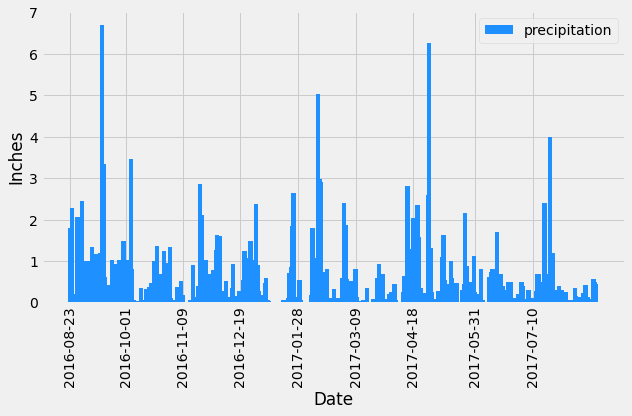

In [11]:
# design a query to retrieve the last 12 months of precipitation data and plot the results

# calculate the date 1 year ago from the last data point in the database
last_date = dt.date(2017, 8, 23)
year_ago = last_date - dt.timedelta(days=365)

# perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).filter(Measurement.date <= last_date).all()

# save the query results as a Pandas DataFrame and set the index to the date column
scores_df = pd.DataFrame(results)
scores_df.set_index("date", inplace=True)

# sort the dataframe by date
scores_sorted = scores_df.sort_index()

# use Pandas Plotting with Matplotlib to plot the data
precipitation = scores_sorted.prcp.tolist()

plt.figure(figsize=(9, 6))
plt.bar(scores_sorted.index, precipitation, color="dodgerblue", width=3, linewidth=4)

plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["precipitation"], loc="upper right")

plt.xticks(scores_sorted.index[::250], rotation="90")
plt.tight_layout()
plt.show()

In [12]:
# use Pandas to calculate the summary statistics for the precipitation data
scores_sorted.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# design a query to show how many stations are available in this dataset:
# store query of station column elements
stations = session.query(Measurement.station).all()

# empty list to store unique stations from our query
unique_stations = []

# loop through query - check if station exists in unique_stations list or not - append if not
for station in stations:
    if station not in unique_stations:
        unique_stations.append(station)

# display how many stations are available in the Measurement dataset
len(unique_stations)

9

In [14]:
# what are the most active stations? (i.e. what stations have the most rows)?
# list the stations and the counts in descending order.
sel = [Measurement.station,
       Station.name,
       func.count(Measurement.prcp)]

stations_counts = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.prcp).desc()).all()

stations_counts

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2696),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2685),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2572),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2484),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 1937),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1932),
 ('USC00517948', 'PEARL CITY, HI US', 683),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 342)]

In [15]:
# first station in the descending list has the highest number of observations
stations_counts[0]

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

In [16]:
# using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station,
      Station.name,
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]

active_station = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.station == 'USC00519281').all()

# display query results for the most active station
print(f"{active_station}\n")
print(f"For the station located in {active_station[0][1]}:")
print(f"The lowest temperature recorded was {active_station[0][2]}.")
print(f"The highest temperature recorded was {active_station[0][3]}.")
print(f"The average temperature recorded was {round(active_station[0][4],2)}.")

[('USC00519281', 'WAIHEE 837.5, HI US', 54.0, 85.0, 71.66378066378067)]

For the station located in WAIHEE 837.5, HI US,
The lowest temperature recorded was 54.0.
The highest temperature recorded was 85.0.
The average temperature recorded was 71.66.


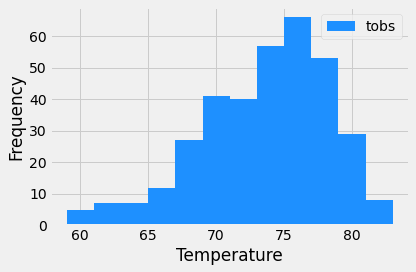

In [17]:
# choose the station with the highest number of temperature observations.
# query the last 12 months of temperature observation data for this station
station_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= year_ago).filter(Measurement.date <= last_date).\
    filter(Measurement.station == 'USC00519281').all()

# save the query results as a Pandas DataFrame and set the index to the date column
station_temp_df = pd.DataFrame(station_results)
station_temp_df.set_index("date", inplace=True)

# sort the dataframe by date
station_sorted = station_temp_df.sort_index()

# plot the results as a histogram (with bins=12 as instructed)
plt.hist(station_sorted["tobs"], color="dodgerblue", bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"], loc="upper right")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [55]:

# query the min temp, avg temp, and max temp for
# all dates greater than and equal to start date
sel = [Measurement.date,
    func.min(Measurement.tobs),
    func.avg(Measurement.tobs),
    func.max(Measurement.tobs)]
    
results = session.query(*sel).\
    group_by(Measurement.date).all()

all_dates = []
for x in range(len(results)):
    dates_dict = {}
    dates_dict["date"] = results[x][0]
    dates_dict["min"] = results[x][1]
    dates_dict["avg"] = round(results[x][2], 2)
    dates_dict["max"] = results[x][3]
    all_dates.append(dates_dict)
    
all_dates

[{'date': '2010-01-01', 'min': 65.0, 'avg': 69.71, 'max': 75.0},
 {'date': '2010-01-02', 'min': 61.0, 'avg': 67.0, 'max': 75.0},
 {'date': '2010-01-03', 'min': 67.0, 'avg': 74.0, 'max': 77.0},
 {'date': '2010-01-04', 'min': 72.0, 'avg': 75.0, 'max': 76.0},
 {'date': '2010-01-05', 'min': 73.0, 'avg': 74.5, 'max': 76.0},
 {'date': '2010-01-06', 'min': 71.0, 'avg': 73.33, 'max': 76.0},
 {'date': '2010-01-07', 'min': 68.0, 'avg': 70.43, 'max': 74.0},
 {'date': '2010-01-08', 'min': 63.0, 'avg': 65.57, 'max': 73.0},
 {'date': '2010-01-09', 'min': 67.0, 'avg': 68.57, 'max': 70.0},
 {'date': '2010-01-10', 'min': 70.0, 'avg': 72.71, 'max': 75.0},
 {'date': '2010-01-11', 'min': 64.0, 'avg': 66.71, 'max': 72.0},
 {'date': '2010-01-12', 'min': 57.0, 'avg': 61.57, 'max': 68.0},
 {'date': '2010-01-13', 'min': 57.0, 'avg': 61.5, 'max': 68.0},
 {'date': '2010-01-14', 'min': 65.0, 'avg': 66.43, 'max': 69.0},
 {'date': '2010-01-15', 'min': 56.0, 'avg': 64.83, 'max': 69.0},
 {'date': '2010-01-16', 'min':

In [22]:
# create list of dates you will be traveling
start = dt.date(2013, 11, 23)
end = dt.date(2013, 11, 29)

index = pd.date_range(start, end)
index

DatetimeIndex(['2013-11-23', '2013-11-24', '2013-11-25', '2013-11-26',
               '2013-11-27', '2013-11-28', '2013-11-29'],
              dtype='datetime64[ns]', freq='D')

In [26]:
# range of years in the data set
sel = [func.min(Measurement.date),
      func.max(Measurement.date)]

years = session.query(*sel).all()

print(years)

[('2010-01-01', '2017-08-23')]


In [27]:
dictionary = dict(years)
dictionary

{'2010-01-01': '2017-08-23'}

In [ ]:
# this function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# plot the results from your previous query as a bar chart. 
# use "Trip Avg Temp" as your Title
# use the average temperature for the y value
# use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# set the start and end date of the trip

# use the start and end date to create a range of dates

# stip off the year and save a list of %m-%d strings

# loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# plot the daily normals as an area plot with `stacked=False`
